# Text retrieval

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

In [2]:
import json

In [3]:
with open('data/queries.json', 'r') as q_file:
    q = json.load(q_file)

In [9]:
query = q['queries'][0]['query']
docs = q['docs']
doc_ids, corpus = [], []
for doc_id, text in docs.items():
    doc_ids.append(doc_id)
    corpus.append(text)

In [8]:
print(query, len(docs))

World War II 7281


In [79]:
q['queries'][0]['docs'][:10]

[29597751,
 25628716,
 352387,
 58343348,
 12816539,
 47104122,
 979204,
 55238997,
 19067213,
 20844834]

## Corpus pre-processing

In [11]:
import spacy

In [12]:
nlp = spacy.load("en_core_web_sm")

In [18]:
def tokenize(text):
    tokens = []
    for sentence in nlp(text).sents:
        for token in sentence:
            if token.pos_ in ['NOUN', 'ADJ', 'ADV', 'VERB', 'PROPN']:
                tokens.append(token.text.lower())
    return tokens

In [15]:
C = []
for text in tqdm_notebook(corpus):
    C.append(tokenize(text))

## Indexing

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import defaultdict

In [56]:
counter = CountVectorizer()
C = counter.fit_transform(corpus)

In [62]:
list(counter.vocabulary_.items())[:10]

[('1901', 703),
 ('1990', 824),
 ('was', 48129),
 ('japanese', 23862),
 ('aircraft', 2811),
 ('designer', 13381),
 ('who', 48575),
 ('worked', 48998),
 ('for', 17873),
 ('mitsubishi', 29861)]

In [75]:
rev_index = dict([(pos, word) for word, pos in counter.vocabulary_.items()])

In [76]:
rev_index[48129]

'was'

In [65]:
C[:,48129].toarray()

array([[ 2],
       [12],
       [ 1],
       ...,
       [ 0],
       [ 0],
       [ 0]])

In [66]:
tfidf = TfidfTransformer(use_idf=True)
X = tfidf.fit_transform(C)

In [67]:
X.shape

(7281, 50532)

### Bag of words

In [80]:
doc = doc_ids.index('979204')
print(corpus[doc])

The Western Desert campaign (Desert War), took place in the deserts of Egypt and Libya and was the main theatre in the North African campaign during the Second World War. The campaign began in September 1940 with the Italian invasion of Egypt; Operation Compass, a British five-day raid in December 1940, led to the destruction of the Italian 10th Army. Benito Mussolini sought help from Adolf Hitler, who responded with a small German force sent to Tripoli under Directive 22 (11 January). The German Afrika Korps (Generalleutnant Erwin Rommel) was under nominal Italian command as the main protagonist in the Mediterranean and North African theaters were the Italians. In the spring of 1941, Axis forces under Rommel pushed the British back to Egypt except for the port of Tobruk, where the Siege of Tobruk took place until Operation Crusader. The Axis forces retired to where they had started by the end of the year. In 1942 Axis forces drove the British back again and captured Tobruk after the B

In [81]:
print(C[doc])

  (0, 120)	1
  (0, 122)	1
  (0, 760)	2
  (0, 762)	3
  (0, 763)	2
  (0, 924)	2
  (0, 2474)	1
  (0, 2638)	2
  (0, 2640)	1
  (0, 2651)	1
  (0, 2667)	1
  (0, 2668)	1
  (0, 2926)	2
  (0, 3137)	1
  (0, 3536)	8
  (0, 4322)	2
  (0, 4438)	1
  (0, 4647)	1
  (0, 5111)	6
  (0, 5218)	2
  (0, 5782)	2
  (0, 5952)	1
  (0, 6002)	2
  (0, 6184)	1
  (0, 7658)	5
  :	:
  (0, 44723)	1
  (0, 44725)	1
  (0, 44738)	2
  (0, 44746)	1
  (0, 44804)	1
  (0, 45173)	11
  (0, 45186)	3
  (0, 45290)	2
  (0, 45846)	1
  (0, 46067)	1
  (0, 46068)	1
  (0, 46424)	3
  (0, 46566)	1
  (0, 46697)	1
  (0, 47427)	1
  (0, 48062)	4
  (0, 48129)	3
  (0, 48399)	1
  (0, 48431)	1
  (0, 48504)	3
  (0, 48575)	1
  (0, 48588)	1
  (0, 48851)	2
  (0, 49014)	1
  (0, 49456)	1


In [83]:
bow = {}
for i in np.nonzero(X[doc,:])[1]:
    bow[rev_index[i]] = {'tf': C[doc,i], 'tfidf': X[doc, i]}
BOW = pd.DataFrame(bow)

In [87]:
BOW.T.sort_values(by='tf', ascending=False).head(10)

,tf,tfidf
the,39.0,0.347210
in,11.0,0.101735
to,11.0,0.156683
of,11.0,0.120611
and,8.0,0.093746
axis,6.0,0.309639
forces,6.0,0.212323
british,5.0,0.116569
war,4.0,0.066626
campaign,4.0,0.162913


## Visual example

In [90]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [94]:
V = PCA(n_components=2).fit(X.toarray())

In [96]:
Xv = V.transform(X.toarray())

In [99]:
wwii = [doc_ids.index(str(x)) for x in q['queries'][0]['docs']]
other = [i for i, x in enumerate(doc_ids) if i not in wwii]

In [110]:
query = 'World War II'
q_vector = tfidf.transform(counter.transform([query]))
qv = V.transform(q_vector.toarray())
qv

array([[-0.08610142, -0.05412651]])

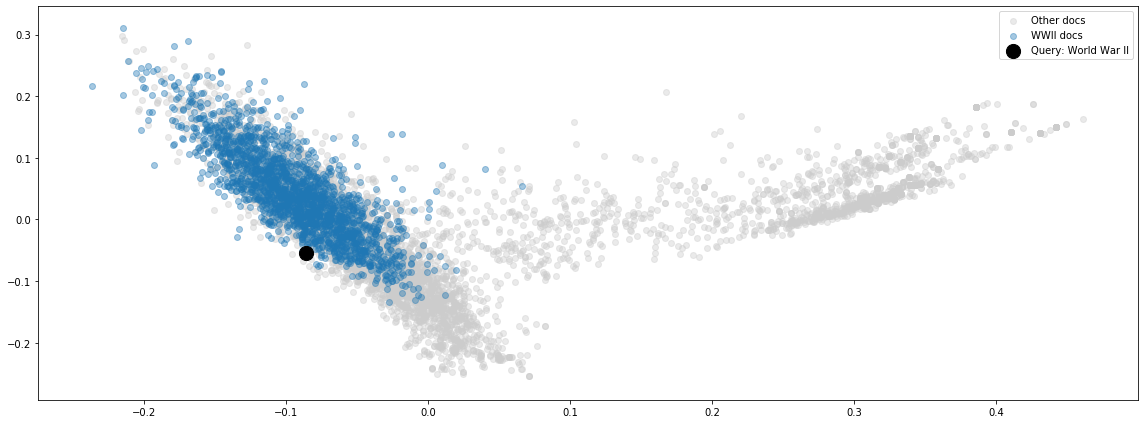

In [119]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.scatter(Xv[other,0], Xv[other,1], label='Other docs', alpha=0.4, c='#cccccc')
ax.scatter(Xv[wwii,0], Xv[wwii,1], label='WWII docs', alpha=0.4)
ax.scatter(qv[:,0], qv[:,1], label='Query: {}'.format(query), s=200, c='#000000')
plt.tight_layout()
plt.legend()
plt.savefig('/Users/alfio/Teaching/2019-20/masterdh/imgs/wwii.png')
plt.show()

## Matching

In [120]:
from sklearn.metrics.pairwise import cosine_similarity

In [123]:
match = cosine_similarity(q_vector, X)

In [132]:
ranking = [(doc_ids[i], x) for i, x in sorted(enumerate(match[0]), key=lambda x: -x[1])]

In [139]:
for doc, cos in ranking[:10]:
    print(doc, '\t', round(cos, 2), '\t', docs[doc][:80])

3873500 	 0.41 	 The 21st Infantry Division was a French Army formation during World War I and Wo
51174098 	 0.39 	 Australian women during World War II played a larger role than they had during W
5265919 	 0.39 	 was a general in the Imperial Japanese Army during World War II.
6326880 	 0.39 	 was a general in the Imperial Japanese Army during World War II.
10135800 	 0.34 	 , was a lieutenant general in the Imperial Japanese Army during World War II.
14972174 	 0.33 	 The was an army of the Imperial Japanese Army during World War II.
48140574 	 0.33 	 This is a bibliography of works on World War II.
340365 	 0.33 	 was a General in the Imperial Japanese Army in World War II and a War Minister. 
19986516 	 0.32 	 The was a fleet of the Imperial Japanese Navy established during World War II.
8066473 	 0.31 	 Theodor "Theo" Osterkamp (15 April 1892 – 2 January 1975) was a German fighter p


## Evaluation

In [181]:
answers = [doc_ids[i] for i, x in sorted(enumerate(match[0]), key=lambda x: -x[1]) if x > 0.03]
doc_score = dict([(doc_ids[i], x) for i, x in sorted(enumerate(match[0]), key=lambda x: -x[1]) if x > 0.03])
E, R, S = [], [], []
for doc in doc_ids:
    if doc in answers:
        R.append(1)
        S.append(doc_score[doc])
    else:
        R.append(0)
        S.append(0)
    if int(doc) in q['queries'][0]['docs']:
        E.append(1)
    else:
        E.append(0)

In [184]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve, roc_curve

In [172]:
print(classification_report(E, R))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      5358
           1       0.70      0.86      0.78      1923

    accuracy                           0.87      7281
   macro avg       0.83      0.87      0.84      7281
weighted avg       0.88      0.87      0.87      7281



In [173]:
cm = confusion_matrix(E, R)

In [174]:
d = ConfusionMatrixDisplay(cm, display_labels=[0, 1])

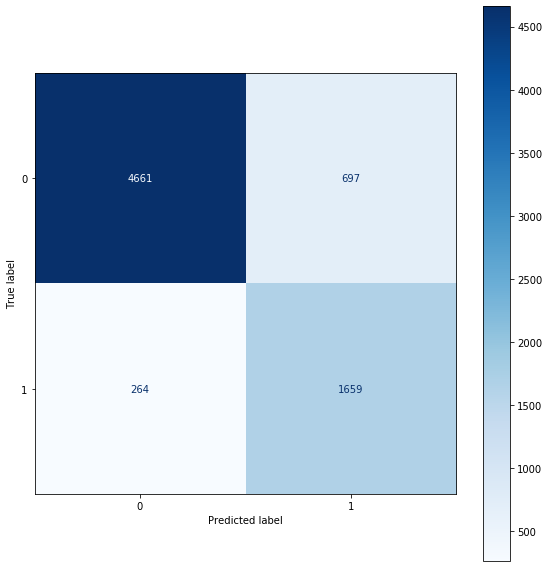

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))
d.plot(ax=ax, cmap='Blues', values_format='d')
plt.tight_layout()
plt.savefig('/Users/alfio/Teaching/2019-20/masterdh/imgs/cm.pdf')
plt.show()

In [182]:
precision, recall, thresholds = precision_recall_curve(E, S)

In [187]:
fpr, tpr, thresholds = roc_curve(E, S)

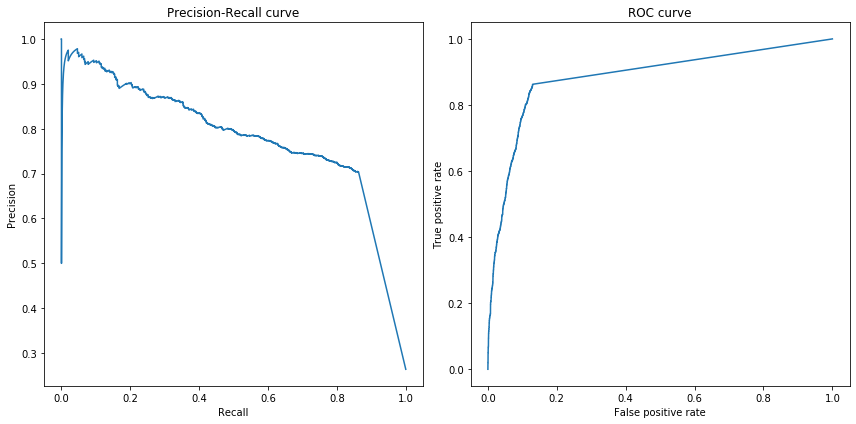

In [192]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].plot(recall, precision)
ax[1].plot(fpr, tpr)
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall curve')
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve')
plt.tight_layout()
plt.savefig('/Users/alfio/Teaching/2019-20/masterdh/imgs/prcurve.pdf')
plt.show()